# Task 5 学习目标
## 将之前建模调参的结果进行模型融合。 尝试多种融合方案，提交融合结果并打卡。（模型融合一般用于A榜比赛的尾声和B榜比赛的全程）
<li>平均：
    
    简单平均法   
    加权平均法
    
<li>投票：
    
    简单投票法
    加权投票法
    
<li>综合：
    
    排序融合
    log融合
    
<li>stacking:
    
    构建多层模型，并利用预测结果再拟合预测。
    
blending：
    选取部分数据预测训练得到预测结果作为新特征，带入剩下的数据中预测。
    
boosting/bagging（在Task4中已经提及，就不再赘述）

##   stacking\blending 的区别：
### stacking 将若干基学习器获得的预测结果，将预测结果作为新的训练集来训练一个学习器。如下图 假设有五个基学习器，将数据带入五基学习器中得到预测结果，再带入模型六中进行训练预测。但是由于直接由五个基学习器获得结果直接带入模型六中，容易导致过拟合。所以在使用五个及模型进行预测的时候，可以考虑使用K折验证，防止过拟合。

### blending 与stacking不同，blending是将预测的值作为新的特征和原特征合并，构成新的特征值，用于预测。为了防止过拟合，将数据分为两部分d1、d2，使用d1的数据作为训练集，d2数据作为测试集。预测得到的数据作为新特征使用d2的数据作为训练集结合新特征，预测测试集结果。

In [1]:
# 简单投票模型
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier

clf1 = LogisticRegression(random_state=1)
clf2 = RandomForestClassifier(random_state=1)
clf3 = XGBClassifier(learning_rate=0.1, n_estimators=150, max_depth=4, min_child_weight=2, subsample=0.7,objective='binary:logistic')
 
vclf = VotingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('xgb', clf3)])
vclf = vclf .fit(x_train,y_train)
print(vclf .predict(x_test))

NameError: name 'x_train' is not defined

## Stacking

In [3]:
import warnings
warnings.filterwarnings('ignore')
import itertools
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from sklearn import datasets
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB 
from sklearn.ensemble import RandomForestClassifier
from mlxtend.classifier import StackingClassifier
from sklearn.model_selection import cross_val_score, train_test_split
from mlxtend.plotting import plot_learning_curves
from mlxtend.plotting import plot_decision_regions

Accuracy: 0.91 (+/- 0.07) [KNN]
Accuracy: 0.94 (+/- 0.04) [Random Forest]
Accuracy: 0.91 (+/- 0.04) [Naive Bayes]
Accuracy: 0.94 (+/- 0.04) [Stacking Classifier]


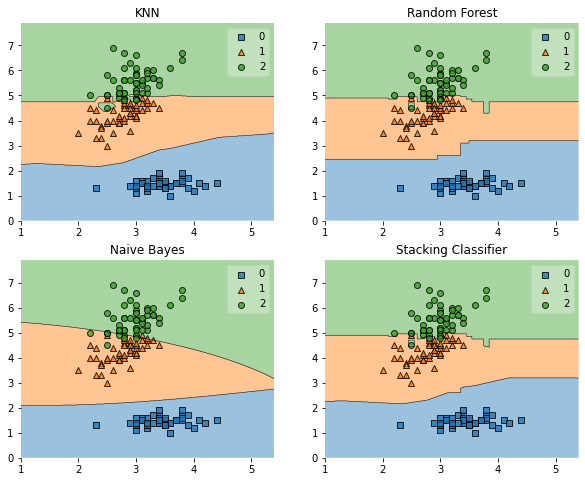

In [2]:
# 以python自带的鸢尾花数据集为例
iris = datasets.load_iris()
X, y = iris.data[:, 1:3], iris.target


clf1 = KNeighborsClassifier(n_neighbors=1)
clf2 = RandomForestClassifier(random_state=1)
clf3 = GaussianNB()
lr = LogisticRegression()
sclf = StackingClassifier(classifiers=[clf1, clf2, clf3], 
                          meta_classifier=lr)


label = ['KNN', 'Random Forest', 'Naive Bayes', 'Stacking Classifier']
clf_list = [clf1, clf2, clf3, sclf]
    
fig = plt.figure(figsize=(10,8))
gs = gridspec.GridSpec(2, 2)
grid = itertools.product([0,1],repeat=2)


clf_cv_mean = []
clf_cv_std = []

for clf, label, grd in zip(clf_list, label, grid):
    scores = cross_val_score(clf, X, y, cv=5, scoring='accuracy')
    print("Accuracy: %.2f (+/- %.2f) [%s]" %(scores.mean(), scores.std(), label))
    clf_cv_mean.append(scores.mean())
    clf_cv_std.append(scores.std())
        
    clf.fit(X, y)
    ax = plt.subplot(gs[grd[0], grd[1]])
    fig = plot_decision_regions(X=X, y=y, clf=clf)
    plt.title(label)
 

plt.show()

## Blending

In [8]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score


# 以python自带的鸢尾花数据集为例
data_0 = iris.data
data = data_0[:100,:]


target_0 = iris.target
target = target_0[:100]
 
#模型融合中基学习器
clfs = [LogisticRegression(),
        RandomForestClassifier(),
        ExtraTreesClassifier(),
        GradientBoostingClassifier()]
 
#切分一部分数据作为测试集
X, X_predict, y, y_predict = train_test_split(data, target, test_size=0.3, random_state=914)


#切分训练数据集为d1,d2两部分
X_d1, X_d2, y_d1, y_d2 = train_test_split(X, y, test_size=0.5, random_state=914)
dataset_d1 = np.zeros((X_d2.shape[0], len(clfs)))
dataset_d2 = np.zeros((X_predict.shape[0], len(clfs)))
 
for j, clf in enumerate(clfs):
    #依次训练各个单模型
    clf.fit(X_d1, y_d1)
    y_submission = clf.predict_proba(X_d2)[:, 1]
    dataset_d1[:, j] = y_submission
    #对于测试集，直接用这k个模型的预测值作为新的特征。
    dataset_d2[:, j] = clf.predict_proba(X_predict)[:, 1]
    print("val auc Score: %f" % roc_auc_score(y_predict, dataset_d2[:, j]))


#融合使用的模型
clf = GradientBoostingClassifier()
clf.fit(dataset_d1, y_d2)
y_submission = clf.predict_proba(dataset_d2)[:, 1]
print("Val auc Score of Blending: %f" % (roc_auc_score(y_predict, y_submission)))

val auc Score: 1.000000
val auc Score: 1.000000
val auc Score: 1.000000
val auc Score: 1.000000
Val auc Score of Blending: 1.000000
